In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("dataset.csv")
data.head()

,Unnamed: 0,X,ozone,radiation,temperature,wind
0,1,1,41,190,67,7.4
1,2,2,36,118,72,8.0
2,3,3,12,149,74,12.6
3,4,4,18,313,62,11.5
4,5,5,23,299,65,8.6


In [3]:
# first two columns are unnecessary (index)
data.drop(data.columns[[0, 1]], axis = 1, inplace = True)
data.head()

,ozone,radiation,temperature,wind
0,41,190,67,7.4
1,36,118,72,8.0
2,12,149,74,12.6
3,18,313,62,11.5
4,23,299,65,8.6


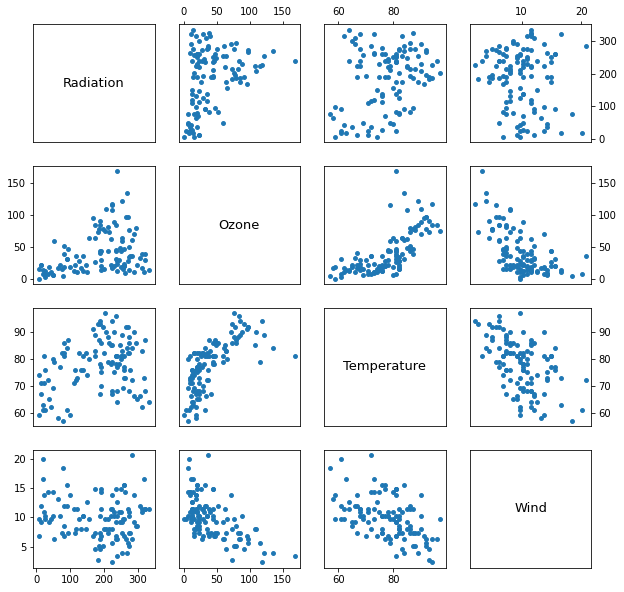

In [59]:
labels = ["radiation", "ozone", "temperature", "wind"]
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(10, 10)
for i in range(4):
    for j in range(4):
        axs[i, j].axes.xaxis.set_visible(False)
        axs[i, j].axes.yaxis.set_visible(False)
        if i == j:
            axs[i, j].plot()
            axs[i, j].text(.5, .5, labels[i].capitalize(),  horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes, fontsize=13)
        else:
            if i == 0 or i == 3:
                axs[i, j].axes.xaxis.set_visible(True)
            if i == 0:
                axs[i, j].xaxis.tick_top()
            if j == 0 or j == 3:
                axs[i, j].axes.yaxis.set_visible(True)
            if j == 3:
                axs[i, j].yaxis.tick_right()
            axs[i, j].scatter(data[labels[j]], data[labels[i]], s=15)

In [67]:
# normalize data
data = (data - data.min()) / (data.max() - data.min())

In [73]:
A = np.array(data[["radiation", "temperature", "wind"]])
b = np.array(data["ozone"])
print(A.shape)
print(b.shape)

(111, 3)
(111,)
